### Overview
This notebook reads a pre-processed set of **English questions** from Kenyan farmers, selects questions on **cattle**;   
tokenizes words, removes stopwords, & lemmatizes verbs; creates bi-and tri-grams and network visualizations

### Inputs: (files saved to your working directory)
* CSV file of cleaned / lower case /  punctuation removed questions: 'kenya_eng_q_clean.csv'
* created by *question_preprocess.ipynb* --> *kenya-q_eng.ipynb* notebook code

### Output files (in working directory)
* CSV file of top 500 bigrams: 'ken_eng_bigrams_top500_cattle.csv'
* CSV file of top 500 trigrams:  'ken_eng_trigrams_top500_cattle.csv'
* HTML file of interactive network diagram of top 40 bigrams: '40bigram_eng_ken_cattle_network.html'                                     
* HTML file of interactive network diagram of top 40 trigrams: '40trigram_eng_ken_cattle_network.html'
                                         
### Steps:
1. Select questions topic == 'cattle'
2. Tokenize - takes ~ 3-4 min to run
3. Remove stopwords & lemmatise verbs
4. Create english bigrams, trigrams, & quadgrams; save as csv files
5. Plot frequency distribution of top 20 bigrams, trigrams
6. Plot & save interactive network graphs of top 40 bigrams and trigrams
7. Save top 500 bi- and tri- grams in CSV files
                                                                                                                                                                       
### Local Variables (partial list):
* q_df       
* ken_q_list
* ken_eng_tokens
* all_bigrams
* all_trigrams
* bigram_freq
* unigram_freq                                          
* trigram_freq
                                                                                                                                                                                                    

In [3]:
#import packages:  pandas, numpy,nltk, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import string
import re

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.util import bigrams
from nltk.util import trigrams
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

#first - pyvis install in conda prompt: 'conda install conda-forge::pyvis'
from pyvis.network import Network

from collections import Counter

from IPython.display import HTML, display, IFrame


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
#load processed country question file
q_df = pd.read_csv('kenya_eng_q_clean.csv')
q_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384774 entries, 0 to 1384773
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   Unnamed: 0      1384774 non-null  int64 
 1   question_id     1384774 non-null  int64 
 2   question_topic  1083079 non-null  object
 3   question_clean  1384774 non-null  object
dtypes: int64(2), object(2)
memory usage: 42.3+ MB


In [7]:
#select questions with topic = 'cattle':

eng_kenya_df=q_df.loc[(q_df['question_topic'] == 'cattle'),['question_id', 'question_topic', 'question_clean']]
len(eng_kenya_df)
#eng_kenya_df = clean_df.loc[(clean_df['question_topic'] != ''),['question_clean']]
eng_kenya_df.head()


,question_id,question_topic,question_clean
10,3850404,cattle,how do we milk a sick cow
16,3850591,cattle,for how long does a cow needs to rest during ...
30,3851366,cattle,what is the importans of feeding cows with dr...
66,3853226,cattle,which is the best suppliment milk to the calf
82,3853857,cattle,what are non_chemical methods of controlling ...


In [8]:
print("the number of english cattle questions: ", len(eng_kenya_df))

the number of english cattle questions:  164312


In [9]:
#create list of questions to be tokenized:
ken_q_list=list(eng_kenya_df['question_clean'])
print(ken_q_list[0:5])


['  how  do  we  milk  a   sick  cow ', ' for how long does a cow needs to rest during the night ', ' what is the importans of feeding cows with dry feeds', ' which is the  best  suppliment milk to the calf', ' what are non_chemical methods of controlling ticks in cattle']


In [10]:
# Define functions to tokenize list of questions:  


stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def normalize_verbs(token_list):
    """Lemmatize verbs only."""
    return [lemmatizer.lemmatize(tok, wordnet.VERB) for tok in token_list]

def tokenize_stopwords_normalize(str_list):
    processed = []

    for text in str_list:
        # 1️⃣ tokenize
        tokens = word_tokenize(text)

        # 2️⃣ remove stopwords
        tokens = [
            t for t in tokens
            if t not in stop_words 
        ]

        # 3️⃣ normalize verbs
        tokens = normalize_verbs(tokens)

        processed.append(tokens)

    return processed

In [11]:
ken_eng_tokens = tokenize_stopwords_normalize(ken_q_list)
print(ken_eng_tokens[0:5])
print("Number of tokens: ", len(ken_eng_tokens))

[['milk', 'sick', 'cow'], ['long', 'cow', 'need', 'rest', 'night'], ['importans', 'feed', 'cow', 'dry', 'feed'], ['best', 'suppliment', 'milk', 'calf'], ['non_chemical', 'methods', 'control', 'tick', 'cattle']]
Number of tokens:  164312


In [12]:
#create list of bigrams:
all_bigrams = []

for question in ken_eng_tokens:
    #create bigrams iterator for each element of tokens: ken_eng_tokens.csv
    bigram_iterator = bigrams(question)
    bigram_list = list(bigram_iterator)

    # Add the bigrams of the current question to the overall list
    all_bigrams.extend(bigram_list)

In [13]:
#create list of trigrams, if # tokens >= 3
all_trigrams = []

for question in ken_eng_tokens:
    if len(question) < 3:
        continue
            #create bigrams iterator for each element of tokens: 
    else:
        all_trigrams.extend(list(trigrams(question)))


In [14]:
print("# of trigrams: ", len(all_trigrams))
print(all_trigrams[0:5])
type(all_trigrams)

# of trigrams:  722042
[('milk', 'sick', 'cow'), ('long', 'cow', 'need'), ('cow', 'need', 'rest'), ('need', 'rest', 'night'), ('importans', 'feed', 'cow')]


list

In [15]:
print("# of bigrams: ", len(all_bigrams))
print(all_bigrams[0:5])
type(all_bigrams)

# of bigrams:  886135
[('milk', 'sick'), ('sick', 'cow'), ('long', 'cow'), ('cow', 'need'), ('need', 'rest')]


list

In [16]:
bigram_freq = Counter(all_bigrams)
#type(bigram_freq)

In [17]:
trigram_freq = Counter(all_trigrams)
#type(trigram_freq)

### Bigram Visualizations:  Note - drop "reply, response" and "follow, response"  bigrams (index = 5,7)

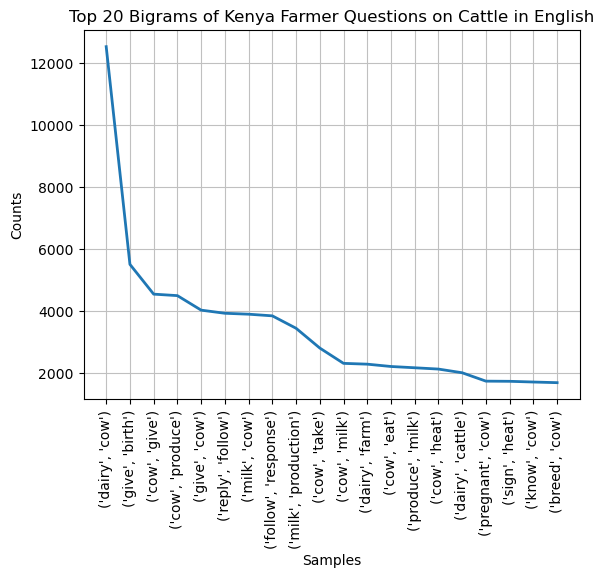

In [18]:
#plot frequency distribution of bigrams
fdist = FreqDist(all_bigrams)
top_n = 20   # change to desired number
fdist.plot(top_n, title=f"Top {top_n} Bigrams of Kenya Farmer Questions on Cattle in English")
#plt.text(0.5, 1.02, "Source:  WeFarm SMS platform messages among farmers in East Africa, 2022" , fontsize=10, ha='center')
plt.savefig("top20bigrams_cattle_ken_eng.png")

In [19]:
#unigram counts for node-size based on token frequency:
 
unigram_freq = Counter(tok for tokens in ken_eng_tokens for tok in tokens)
print(unigram_freq.most_common(75))

[('cow', 120278), ('milk', 27552), ('dairy', 25079), ('give', 20299), ('best', 16524), ('calf', 14876), ('cattle', 13671), ('use', 10016), ('problem', 10003), ('bull', 9044), ('get', 8885), ('heat', 8554), ('ask', 8156), ('produce', 8025), ('breed', 7731), ('birth', 7565), ('cause', 7547), ('many', 7531), ('take', 7268), ('fee', 7231), ('salt', 7016), ('good', 6901), ('type', 6894), ('one', 6647), ('long', 6513), ('feed', 6060), ('production', 5431), ('sign', 5134), ('time', 4979), ('calve', 4972), ('months', 4875), ('pregnant', 4587), ('follow', 4380), ('reply', 4310), ('know', 4292), ('eat', 4286), ('deworm', 4205), ('medicine', 4015), ('heifer', 3907), ('response', 3905), ('want', 3903), ('day', 3897), ('farm', 3883), ('need', 3839), ('make', 3627), ('keep', 3543), ('serve', 3471), ('disease', 3275), ('could', 3249), ('month', 3159), ('start', 3077), ('help', 2983), ('show', 2926), ('much', 2826), ('water', 2773), ('might', 2768), ('spray', 2709), ('like', 2678), ('skin', 2661), ('f

In [23]:
print(bigram_freq.most_common()[:5], bigram_freq.most_common()[6], bigram_freq.most_common()[8:42])
#len(bigram_freq.most_common()[:6] + bigram_freq.most_common()[6] + bigram_freq.most_common()[8:42])

[(('dairy', 'cow'), 12520), (('give', 'birth'), 5510), (('cow', 'give'), 4551), (('cow', 'produce'), 4503), (('give', 'cow'), 4036)] (('milk', 'cow'), 3905) [(('milk', 'production'), 3452), (('cow', 'take'), 2815), (('cow', 'milk'), 2322), (('dairy', 'farm'), 2296), (('cow', 'eat'), 2221), (('produce', 'milk'), 2180), (('cow', 'heat'), 2138), (('dairy', 'cattle'), 2019), (('pregnant', 'cow'), 1749), (('sign', 'heat'), 1744), (('know', 'cow'), 1721), (('breed', 'cow'), 1700), (('per', 'day'), 1649), (('cow', 'get'), 1629), (('best', 'dairy'), 1591), (('deworm', 'cow'), 1573), (('could', 'problem'), 1551), (('might', 'problem'), 1519), (('fee', 'cow'), 1517), (('show', 'sign'), 1450), (('make', 'cow'), 1390), (('salt', 'give'), 1366), (('ask', 'cow'), 1315), (('dairy', 'meal'), 1312), (('type', 'cow'), 1257), (('problem', 'cow'), 1250), (('good', 'dairy'), 1182), (('increase', 'milk'), 1152), (('best', 'salt'), 1147), (('best', 'breed'), 1122), (('spray', 'cow'), 1111), (('dairy', 'goat'

In [28]:
top_bigrams = bigram_freq.most_common(top_n+2)
type(top_bigrams)
del top_bigrams[5]

del top_bigrams[6]
top_bigrams

[(('dairy', 'cow'), 12520),
 (('give', 'birth'), 5510),
 (('cow', 'give'), 4551),
 (('cow', 'produce'), 4503),
 (('give', 'cow'), 4036),
 (('milk', 'cow'), 3905),
 (('milk', 'production'), 3452),
 (('cow', 'take'), 2815),
 (('cow', 'milk'), 2322),
 (('dairy', 'farm'), 2296),
 (('cow', 'eat'), 2221),
 (('produce', 'milk'), 2180),
 (('cow', 'heat'), 2138),
 (('dairy', 'cattle'), 2019),
 (('pregnant', 'cow'), 1749),
 (('sign', 'heat'), 1744),
 (('know', 'cow'), 1721),
 (('breed', 'cow'), 1700),
 (('per', 'day'), 1649),
 (('cow', 'get'), 1629),
 (('best', 'dairy'), 1591),
 (('deworm', 'cow'), 1573),
 (('could', 'problem'), 1551),
 (('might', 'problem'), 1519),
 (('fee', 'cow'), 1517),
 (('show', 'sign'), 1450),
 (('make', 'cow'), 1390),
 (('salt', 'give'), 1366),
 (('ask', 'cow'), 1315),
 (('dairy', 'meal'), 1312),
 (('type', 'cow'), 1257),
 (('problem', 'cow'), 1250),
 (('good', 'dairy'), 1182),
 (('increase', 'milk'), 1152),
 (('best', 'salt'), 1147),
 (('best', 'breed'), 1122),
 (('spra

In [29]:
#create interactive directed network chart...with help from Anaconda toolbox

# Variables:
# - bigram_freq: Counter object with bigram frequencies (ranging from ~900 to 10000)
# - unigram_freq: Counter object with country unigram frequencies (up to ~ 100000)

# Get top 40 bigrams, excluding the 11th and 12th:  
top_n = 40
top_bigrams = bigram_freq.most_common(top_n+2) 
del top_bigrams[5]
del top_bigrams[6]
 
# Create a graph
G = nx.DiGraph()

# Add edges (bigrams) with weights based on frequency
for bigram, frequency in top_bigrams:
    word1, word2 = bigram
    G.add_edge(word1, word2, value=frequency, title=f"Frequency: {frequency}")

# Calculate node sizes based on unigram frequencies
max_node_size = 50  # Maximum node size for visualization
min_node_size = 10  # Minimum node size for visualization

# Get all unique words from the bigrams
all_words = set()
for bigram, _ in top_bigrams:
    all_words.add(bigram[0])
    all_words.add(bigram[1])

# Set node sizes based on unigram frequencies
for word in all_words:
    # Get frequency from unigram counter, default to minimum if not found
    frequency = unigram_freq.get(word, 10000)
    
    # Scale node size based on frequency
    # Map from range [5000, 15000] to [min_node_size, max_node_size]
    size = min_node_size + (max_node_size - min_node_size) * (
        (frequency) / (100000)
    ) if frequency >= 10000 else min_node_size
    
    # Set node attributes
    G.nodes[word]['size'] = size
    G.nodes[word]['title'] = f"{word}: {frequency}"
    G.nodes[word]['label'] = word

# Create interactive network
net = Network(notebook=True, height="750px", width="100%", bgcolor="#ffffff", font_color="black")
net.from_nx(G)

# Configure physics for better visualization
net.toggle_physics(True)
net.barnes_hut(gravity=-2000, central_gravity=0.3, spring_length=150)

# Add edge thickness based on bigram frequency

for edge in net.edges:
    # Scale edge width based on weight
   weight = edge['value']
    # Map from range [900, 10000] to [1, 10] for edge width
   edge['width'] = 1 + 9 * ((weight - 900) / (10000 - 900)) if weight >= 900 else 1
   edge['title'] = f"Frequency: {weight}"

    # Improve arrow visibility
   edge['arrows'] = 'to'
   edge['smooth'] = {'type': 'curvedCW', 'roundness': 0.2}  # Curved edges for better visibility
   edge['color'] = {'opacity': 0.5} 
    
# Add some color to distinguish nodes
subdued_colors = [
    '#7D9D9C', '#576F72', '#8B9A46', '#A4BE7B', '#5F7161', 
    '#6D8B74', '#94B49F', '#B4CFB0', '#9CB4CC', '#748DA6',
    '#6096B4', '#93BFCF', '#BDCDD6', '#9F73AB', '#A084DC'
]

for i, node in enumerate(net.nodes):
     node['font'] = {'bold': True, 'size': 16, 'face': 'arial'}
     node['color'] = subdued_colors[i % len(subdued_colors)]
     node['borderWidth'] = 2
     node['borderWidthSelected'] = 4


# Save the HTML file with the title and legend included
filename = "40bigram_eng_ken_cattle_network.html"
net.write_html(filename) 
print(f"Visualization saved as '{filename}'")

# Inject title + subtitle inside the iframe display
with open(filename, "r", encoding="utf-8") as f:
    html = f.read()

    header_html = f"""
    <div style="text-align:center; font-family:Arial; padding-top:10px;">
        <h1 style="margin-bottom:2px; font-size:20px;">Network Graph: Top 40 Bigrams from Kenyan Farmer Questions on Cattle on English</h1>
        <h3 style="margin-top:0; color:#555; font-size:14px;">Word circle size = word frequency, arrow width = bigram frequency, Source: WeFarm 2022 SMS Platform</h3>
        <hr style="width:80%; margin-top:10px; margin-bottom:15px;">
    </div>
    """

# Insert heading right after <body>
html = html.replace("<body>", "<body>" + header_html)

with open(filename, "w", encoding="utf-8") as f:
    f.write(html)

# Display in notebook
display(IFrame(filename, width="100%", height="800px"))


Visualization saved as '40bigram_eng_ken_cattle_network.html'


### Trigram Visualizations:  Note - most frequent trigram isn't informative, so should be dropped

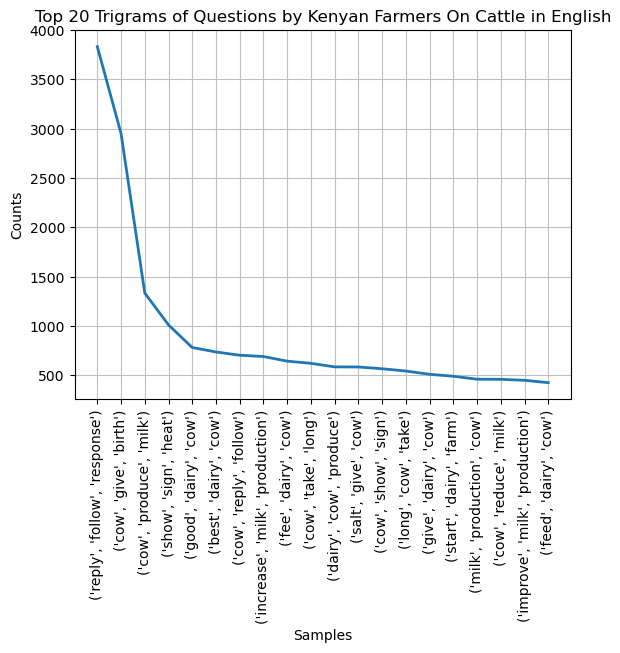

In [30]:
#plot frequency distribution of trigrams
fdist = FreqDist(all_trigrams)
top_n = 20   # change to desired number
fdist.plot(top_n, title=f"Top {top_n} Trigrams of Questions by Kenyan Farmers On Cattle in English")
plt.savefig("top20trigrams_cattle_ken_eng.png")

In [17]:
from IPython.display import IFrame

In [31]:
#interactive directed network graph of top 30 trigrams...with help from Anaconda Assistant

# Input variables:
# - trigram_freq: Counter object with trigram frequencies (ranging from 200 to 1800)
# - unigram_freq: Counter object with unigram frequencies (up to 100000)

#choose most frequent N bigrams, after dropping 1st trigram:
top_n = 40
top_trigrams = trigram_freq.most_common()[1:top_n+1]

# Create a directed graph
G = nx.DiGraph()

# For trigrams, we'll create a path: word1 -> word2 -> word3
for trigram, frequency in top_trigrams:
    word1, word2, word3 = trigram
    
    # Add edges with weights based on frequency
    G.add_edge(word1, word2, value=frequency, title=f"Part of trigram: {' '.join(trigram)}, Frequency: {frequency}")
    G.add_edge(word2, word3, value=frequency, title=f"Part of trigram: {' '.join(trigram)}, Frequency: {frequency}")

# Calculate node sizes based on unigram frequencies
max_node_size = 50  # Maximum node size for visualization
min_node_size = 10  # Minimum node size for visualization

# Get all unique words from the trigrams
all_words = set()
for trigram, _ in top_trigrams:
    all_words.update(trigram)

# Set node sizes based on unigram frequencies
for word in all_words:
    # Get frequency from unigram counter, default to minimum if not found
    frequency = unigram_freq.get(word, 10000)
    
    # Scale node size based on frequency
    # Map from range [5000, 15000] to [min_node_size, max_node_size]
    size = min_node_size + (max_node_size - min_node_size) * (
        (frequency - 10000) / (150000 - 10000)
    ) if frequency >= 10000 else min_node_size

    
    # Set node attributes
    G.nodes[word]['size'] = size
    G.nodes[word]['title'] = f"{word}: {frequency}"
    G.nodes[word]['label'] = word

# Create interactive network with directed edges
net = Network(notebook=True, height="750px", width="100%", bgcolor="#ffffff", font_color="#333333", directed=True)
net.heading = ""

net.from_nx(G)

# Configure physics for better visualization
net.toggle_physics(True)
net.barnes_hut(gravity=-2000, central_gravity=0.3, spring_length=150)

# Subtle color palette
subtle_colors = [
    '#E6E6FA', '#D8BFD8', '#DDA0DD', '#EE82EE', '#DA70D6',
    '#BA55D3', '#9370DB', '#8A2BE2', '#9400D3', '#9932CC',
    '#8B008B', '#800080', '#4B0082', '#6A5ACD', '#483D8B',
    '#7B68EE', '#0000FF', '#0000CD', '#00008B', '#000080'
]

# Add edge thickness based on trigram frequency and make arrows somewhat opaque
for edge in net.edges:
    freq = edge['value']
    # Map from range [200, 1800] to [1, 8] for edge width
    edge['width'] = 1 + 7 * ((freq - 200) / (1800 - 200)) if freq >= 200 else 1
    edge['title'] = f"Frequency: {freq}"
    
    # Somewhat opaque curved arrows
    edge['color'] = {'color': '#848484', 'opacity': 0.5}  # 50% opacity
    edge['arrows'] = {'to': {'enabled': True, 'scaleFactor': 0.6}}
    edge['smooth'] = {'type': 'curvedCW', 'roundness': 0.2}

# Enhance node appearance with bold labels and subtle colors
for i, node in enumerate(net.nodes):
    node['font'] = {'bold': True, 'size': 16, 'face': 'arial'}
    node['color'] = subtle_colors[i % len(subtle_colors)]
    node['borderWidth'] = 2
    node['borderWidthSelected'] = 4

# Save the HTML file with the title and legend included
filename = "40trigram_eng_ken_cattle_network.html"
net.write_html(filename) 
print(f"Visualization saved as '{filename}'")

# Inject title + subtitle inside the iframe display
with open(filename, "r", encoding="utf-8") as f:
    html = f.read()

    header_html = f"""
    <div style="text-align:center; font-family:Arial; padding-top:10px;">
        <h1 style="margin-bottom:2px; font-size:20px;">Network Graph: Top 40 Trigrams from Kenyan Farmers Questions on Cattle in English</h1>
        <h3 style="margin-top:0; color:#555; font-size:14px;">Word circle size = word frequency, arrow width = trigram frequency, Source: WeFarm 2022 SMS Platform</h3>
        <hr style="width:80%; margin-top:10px; margin-bottom:15px;">
    </div>
    """

# Insert heading right after <body>
html = html.replace("<body>", "<body>" + header_html)

with open(filename, "w", encoding="utf-8") as f:
    f.write(html)

#display in notebook:
display(IFrame(filename, width="100%", height="800px"))


Visualization saved as '40trigram_eng_ken_cattle_network.html'


### Save top 500 bigrams, trigrams to CSV files; plot top 40 quadgrams -- not that informative

In [32]:
#find top 500 bigrams:
top_500 = bigram_freq.most_common(500)
#convert top_500 list to df, and join bigrams with '_' as separators for later translation, note: there are no duplicates
ken_bigrams_500_df = pd.DataFrame(top_500, columns=['bigram','count'])
ken_bigrams_500_df["bigram_str"] = ken_bigrams_500_df["bigram"].apply(lambda t: "_".join(t))

In [33]:
#convert top_500 list to df, and join bigrams with '_' as separators for later translation, note: there are no duplicates
ken_bigrams_500_df = pd.DataFrame(top_500, columns=['bigram','count'])
ken_bigrams_500_df["bigram_str"] = ken_bigrams_500_df["bigram"].apply(lambda t: "_".join(t))
ken_bigrams_500_df.head()

,bigram,count,bigram_str
0,"(dairy, cow)",12520,dairy_cow
1,"(give, birth)",5510,give_birth
2,"(cow, give)",4551,cow_give
3,"(cow, produce)",4503,cow_produce
4,"(give, cow)",4036,give_cow


In [34]:
#save in csv file:
ken_bigrams_500_df.to_csv('ken_eng_bigrams_cattle_top500.csv')


In [35]:
#find top 500 trigrams:
top_500 = trigram_freq.most_common(500)
#convert top_500 list to df, and join trigrams with '_' as separators for later translation, note: there are no duplicates
ken_trigrams_500_df = pd.DataFrame(top_500, columns=['trigram','count'])
ken_trigrams_500_df["trigram_str"] = ken_trigrams_500_df["trigram"].apply(lambda t: "_".join(t))
ken_trigrams_500_df.head()

,trigram,count,trigram_str
0,"(reply, follow, response)",3830,reply_follow_response
1,"(cow, give, birth)",2950,cow_give_birth
2,"(cow, produce, milk)",1334,cow_produce_milk
3,"(show, sign, heat)",1011,show_sign_heat
4,"(good, dairy, cow)",782,good_dairy_cow


In [36]:
#save in csv file:
ken_trigrams_500_df.to_csv('ken_eng_trigrams_cattle_top500.csv')


In [37]:
#create list of quadgrams, after checking # tokens >= 4
#from nltk.util import ngrams

all_quadgrams = []

for question in ken_eng_tokens:
    if len(question) < 4:
        continue
            #create bigrams iterator for each element of tokens: 
    else:
        all_quadgrams.extend(list(ngrams(question,4)))
        


In [38]:
print("# of quadgrams: ", len(all_quadgrams))


# of quadgrams:  561336


In [39]:
quadgram_freq = Counter(all_quadgrams)

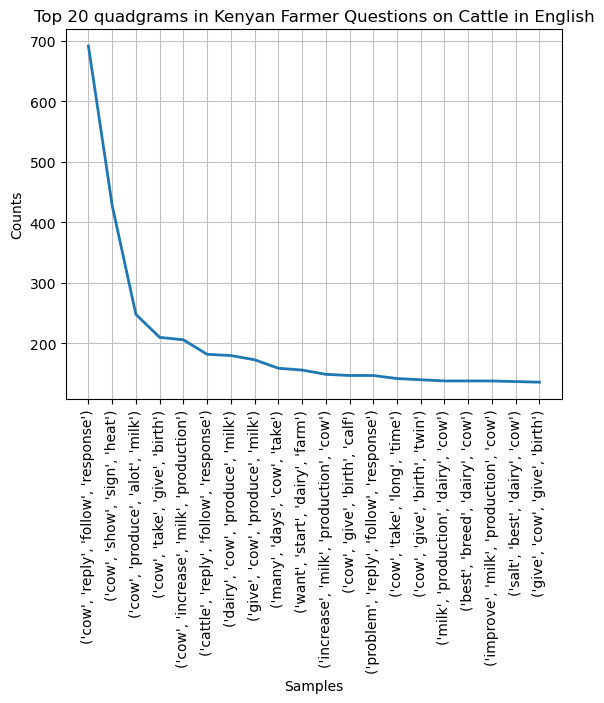

In [40]:
#top 20 quadgram plot

fdist = FreqDist(all_quadgrams)
top_n = 20   # change to desired number
fdist.plot(top_n, title=f"Top {top_n} quadgrams in Kenyan Farmer Questions on Cattle in English")
plt.savefig("top20quadgrams_ken_cattle_eng.png")

In [41]:
#find top 500 quadgrams:
top_500 = quadgram_freq.most_common(500)
#convert top_500 list to df, and join quadgrams with '_' as separators for later translation, note: there are no duplicates
ken_quadgrams_500_df = pd.DataFrame(top_500, columns=['quadgram','count'])
ken_quadgrams_500_df["quadgram_str"] = ken_quadgrams_500_df["quadgram"].apply(lambda t: "_".join(t))

In [42]:
#save in csv file:
ken_quadgrams_500_df.to_csv('ken_eng_quadgrams_cattle_top500.csv')